# Stage 1 - Enrichment with VADER
This first stage reads **Data/raw/**, applies minimal cleaning, adds sentiment analysis with **VADER** and heuristics, aggregates per-post and per-comment metrics, and saves **CSV + JSONL** in **Data/enriched/**.

## Libraries

In [1]:
# Run this cell to install the following dependencies:
# ```bash
# !pip install pandas tqdm vaderSentiment regex
# ```

In [2]:
from pathlib import Path
import json, re
import pandas as pd
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Parameters

In [3]:
DATA_DIR = Path("../data")          # data folder
RAW_DIR = DATA_DIR / "raw"       # folder with raw run
ENRICHED_DIR = DATA_DIR / "enriched"  # folder for enriched data
ENRICHED_DIR.mkdir(parents=True, exist_ok=True)

# Agreement/disagreement heuristics (EN/ES).
AGREE_TERMS = [
    r"\bi agree\b", r"\bagree\b", r"\bsupported\b", r"\bsupport this\b", r"\bi support\b", r"\bvalid point\b",
    r"\bde acuerdo\b", r"\bapoyo\b", r"\btiene raz[oó]n\b", r"\bcierto\b", r"\btotalmente de acuerdo\b", r"\bestoy de acuerdo\b",
]
DISAGREE_TERMS = [
    r"\bi disagree\b", r"\bdisagree\b", r"\bnot support\b", r"\boppose\b", r"\bagainst this\b", r"\bbad take\b",
    r"\bno apoyo\b", r"\ben desacuerdo\b", r"\bno estoy de acuerdo\b", r"\bmala idea\b", r"\bme opongo\b",
]

# Precompiled regular expressions
RE_URL = re.compile(r"https?://\S+")
RE_WS = re.compile(r"\s+")

## Utilities

In [4]:
def latest_raw_dir(raw_base: Path) -> Path:
    """Gets the most recent subfolder in raw_base."""
    subs = [p for p in raw_base.iterdir() if p.is_dir()]
    if not subs:
        raise FileNotFoundError(f"No subfolders found in {raw_base}. Make sure to run the scraper.")
    return sorted(subs)[-1]


def read_csv_or_jsonl(path_csv: Path, path_jsonl: Path) -> pd.DataFrame:
    """Reads a DataFrame from CSV or JSONL, depending on which exists."""
    if path_csv.exists():
        return pd.read_csv(path_csv)
    if path_jsonl.exists():
        return pd.read_json(path_jsonl, lines=True)
    raise FileNotFoundError(f"Neither {path_csv} nor {path_jsonl} was found.")


def minimal_clean_for_vader(text: str) -> str:
    """Minimal cleaning: normalizes spaces and optionally tokenizes URLs.
    Preserves uppercase, punctuation, and emojis for VADER.
    """
    if not isinstance(text, str):
        return ""
    t = RE_URL.sub("URL", text)
    t = RE_WS.sub(" ", t).strip()
    return t


def count_hits_regex(text: str, patterns: list[str]) -> int:
    """Counts how many patterns in 'patterns' match 'text' (case insensitive)."""
    if not text:
        return 0
    t = text.lower()
    return sum(1 for pat in patterns if re.search(pat, t))

## Load raw data

In [5]:
posts_csv = RAW_DIR / "posts.csv"
comments_csv = RAW_DIR / "comments.csv"
posts_jsonl = RAW_DIR / "posts.jsonl"
comments_jsonl = RAW_DIR / "comments.jsonl"

posts = read_csv_or_jsonl(posts_csv, posts_jsonl)
comments = read_csv_or_jsonl(comments_csv, comments_jsonl)
print("Shapes RAW:", posts.shape, comments.shape)

# Ensure basic columns exist
req_posts = ["post_id","title","selftext","author","created","score","num_comments","permalink","is_self","image_urls","subreddit"]
for col in req_posts:
    if col not in posts.columns:
        posts[col] = None

req_comments = ["post_id","comment_id","author","created","score","body"]
for col in req_comments:
    if col not in comments.columns:
        comments[col] = None

Shapes RAW: (200, 18) (11113, 10)


## Minimal cleaning for VADER Analyzis

In [6]:
# Minimal cleaning and features in comments
comments["body"] = comments["body"].fillna("")
comments["body_vader"] = comments["body"].map(minimal_clean_for_vader)
comments["has_url"] = comments["body"].str.contains(r"https?://", na=False)
comments["text_len"] = comments["body"].str.len().fillna(0)
comments["author_deleted"] = comments["author"].isin([None, "u/[deleted]"])
comments["is_bot"] = comments["author"].fillna("").str.contains("automoderator", case=False)

# Remove duplicates and keep clean indices
comments = comments.drop_duplicates(subset=["post_id","comment_id"]).reset_index(drop=True)
posts = posts.drop_duplicates(subset=["post_id"]).reset_index(drop=True)


## Apply VADER and heuristics

In [7]:
# Instantiate VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Initialize lists for scores
v_neg, v_neu, v_pos, v_comp = [], [], [], []

# Iterate and compute scores
for txt in tqdm(comments["body_vader"].tolist(), desc="VADER"):
    scores = analyzer.polarity_scores(txt or "")
    v_neg.append(scores.get("neg", 0.0))
    v_neu.append(scores.get("neu", 0.0))
    v_pos.append(scores.get("pos", 0.0))
    v_comp.append(scores.get("compound", 0.0))

# Assign scores to DataFrame
comments["vader_neg"] = v_neg
comments["vader_neu"] = v_neu
comments["vader_pos"] = v_pos
comments["vader_compound"] = v_comp

# Label from compound (standard thresholds)
comments["sentiment_label"] = pd.cut(
    comments["vader_compound"],
    bins=[-1.0, -0.5, 0.5, 1.0],
    labels=["neg","neu","pos"],
    include_lowest=True
)

# Agreement/disagreement heuristics
comments["agrees"] = comments["body_vader"].map(lambda t: count_hits_regex(t, AGREE_TERMS))
comments["disagrees"] = comments["body_vader"].map(lambda t: count_hits_regex(t, DISAGREE_TERMS))

# Aggregate by post
agg = (
    comments.groupby("post_id", group_keys=False)
    .apply(lambda g: pd.Series({
        "comments_total": g["comment_id"].count(),
        "comments_pos": (g["sentiment_label"] == "pos").sum(),
        "comments_neg": (g["sentiment_label"] == "neg").sum(),
        "comments_neu": (g["sentiment_label"] == "neu").sum(),
        "agree_hits": g["agrees"].sum(),
        "disagree_hits": g["disagrees"].sum(),
    }), include_groups=False)
    .reset_index()
)



# Compute support_index with zero handling
num = agg["comments_pos"] + agg["agree_hits"]
denom = agg["comments_pos"] + agg["comments_neg"] + agg["agree_hits"] + agg["disagree_hits"]
agg["support_index"] = (num / denom.replace({0: pd.NA})).fillna(0.0).round(3)

# Merge aggregated features back to posts
posts_proc = posts.merge(agg, on="post_id", how="left")
for col in ["comments_total","comments_pos","comments_neg","comments_neu","agree_hits","disagree_hits","support_index"]:
    if col not in posts_proc.columns:
        posts_proc[col] = 0 if col != "support_index" else 0.0

VADER: 100%|██████████| 11113/11113 [00:00<00:00, 14754.83it/s]
/var/folders/1_/typt0bhn7_q_v0p0c8csdvmh0000gn/T/ipykernel_10742/2335628906.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  agg["support_index"] = (num / denom.replace({0: pd.NA})).fillna(0.0).round(3)


## Save data (CSV + JSONL)

In [8]:
comments_out_csv = ENRICHED_DIR / "comments_with_vader.csv"
comments_out_jsonl = ENRICHED_DIR / "comments_with_vader.jsonl"
posts_out_csv = ENRICHED_DIR / "posts_with_support.csv"
posts_out_jsonl = ENRICHED_DIR / "posts_with_support.jsonl"

comments.to_csv(comments_out_csv, index=False, encoding="utf-8-sig")
posts_proc.to_csv(posts_out_csv, index=False, encoding="utf-8-sig")

with open(comments_out_jsonl, "w", encoding="utf-8") as f:
    for _, row in comments.iterrows():
        f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")

with open(posts_out_jsonl, "w", encoding="utf-8") as f:
    for _, row in posts_proc.iterrows():
        f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")

print("Done.")
print("comments_with_vader:", comments.shape, "→", comments_out_csv)
print("posts_with_support:", posts_proc.shape, "→", posts_out_csv)

Done.
comments_with_vader: (11113, 18) → ../data/enriched/comments_with_vader.csv
posts_with_support: (200, 32) → ../data/enriched/posts_with_support.csv


# Stage 2: Full Preprocessing

This second stage reads **Data/enriched/** produced in stage one, and applies language detection, cleaning, and feature extraction.

## Libraries

In [9]:
# Run this cell to install the following dependencies:
# ```bash
# pip install pandas tqdm langdetect regex unidecode
# ```

In [10]:
from pathlib import Path
from dataclasses import dataclass
import json, math, unicodedata
import pandas as pd
import numpy as np
from tqdm import tqdm
from langdetect import detect_langs, DetectorFactory
import re
from unidecode import unidecode
import regex as rx

## Parameters

In [11]:
# Determinism for langdetect
DetectorFactory.seed = 0

# Data paths
DATA_DIR = Path("../data")                 # base data directory
ENRICHED_DIR = DATA_DIR / "enriched"    # enriched data directory
OUT_DIR = DATA_DIR / "processed"        # processed data directory
# Create output directory if it doesn't exist
OUT_DIR.mkdir(parents=True, exist_ok=True)

# File paths
COMMENTS_IN_CSV = ENRICHED_DIR / "comments_with_vader.csv"
COMMENTS_IN_JSONL = ENRICHED_DIR / "comments_with_vader.jsonl"
POSTS_IN_CSV = ENRICHED_DIR / "posts_with_support.csv"
POSTS_IN_JSONL = ENRICHED_DIR / "posts_with_support.jsonl"

# Precompiled regular expressions
RE_URL = re.compile(r"https?://\S+", re.I)
RE_USER = re.compile(r"\bu/\w+", re.I)
RE_SUB = re.compile(r"\br/\w+", re.I)
RE_WS = re.compile(r"\s+")

# Non-alphanumeric characters
RE_NON_ALNUM = rx.compile(r"[^\p{L}\p{N}\s]", rx.UNICODE)

## Utilities

In [12]:
def read_df(csv_path: Path, jsonl_path: Path) -> pd.DataFrame:
    """Reads a DataFrame from CSV or JSONL, whichever exists."""
    if csv_path.exists():
        return pd.read_csv(csv_path)
    if jsonl_path.exists():
        return pd.read_json(jsonl_path, lines=True)
    raise FileNotFoundError(f"Neither {csv_path} nor {jsonl_path} was found.")


def safe_len(s: str) -> int:
    """Returns the length of a string safely."""
    try:
        return len(s)
    except Exception:
        return 0


def detect_language(text: str) -> str:
    """Detects language ('en','es',...) or 'unk'. Uses langdetect with error handling."""
    if not isinstance(text, str):
        return "unk"
    t = text.strip()
    if len(t) < 3:
        return "unk"
    try:
        probs = detect_langs(t)
        if not probs:
            return "unk"
        # takes the language with the highest probability
        best = max(probs, key=lambda p: p.prob)
        # normalizes long codes (e.g. 'en' is fine, 'pt-BR' -> 'pt')
        code = str(best.lang).split('-')[0].lower()
        return code
    except Exception:
        return "unk"


def clean_text_ml(text: str, lang: str) -> str:
    """Cleans text for modeling: lowercasing, removing URLs/users/subs, removing punctuation.
    Normalizes spaces and accents. Preserves numbers."""
    # Check type
    if not isinstance(text, str):
        return ""
    # Remove URLs, users, and subreddits
    t = RE_URL.sub(" ", text)
    t = RE_USER.sub(" ", t)
    t = RE_SUB.sub(" ", t)
    # removes special non-alphanumeric characters
    t = rx.sub(r"[\p{C}\p{Zl}\p{Zp}]", " ", t)  # controls for rare separators
    # Replaces non-alphanumerics with space
    t = RE_NON_ALNUM.sub(" ", t)
    # normalizes spaces
    t = RE_WS.sub(" ", t).strip()
    # lowercases and removes accents
    t = t.lower()
    t = unidecode(t)
    return t

## Load data enriched data

In [13]:
comments = read_df(COMMENTS_IN_CSV, COMMENTS_IN_JSONL)
posts = read_df(POSTS_IN_CSV, POSTS_IN_JSONL)

# Normalize expected minimal columns
for col in ["post_id","comment_id","author","created","score","body","body_vader",
            "vader_neg","vader_neu","vader_pos","vader_compound","sentiment_label",
            "agrees","disagrees","has_url","text_len","author_deleted","is_bot"]:
    if col not in comments.columns:
        comments[col] = np.nan

for col in ["post_id","title","selftext","author","created","score","num_comments",
            "permalink","is_self","image_urls","subreddit",
            "comments_total","comments_pos","comments_neg","comments_neu",
            "agree_hits","disagree_hits","support_index"]:
    if col not in posts.columns:
        posts[col] = np.nan

## Duplicates, nulls, and types

In [14]:
# Keep original text before cleaning
comments["body_raw"] = comments["body"]

# Remove duplicates and correct types
comments = comments.drop_duplicates(subset=["post_id","comment_id"])
comments["score"] = pd.to_numeric(comments["score"], errors="coerce").astype("Int64")
comments["created"] = pd.to_datetime(comments["created"], errors="coerce", utc=True)
posts = posts.drop_duplicates(subset=["post_id"])
posts["score"] = pd.to_numeric(posts["score"], errors="coerce").astype("Int64")
posts["created"] = pd.to_datetime(posts["created"], errors="coerce", utc=True)

# Normalizes dates and nulls
comments["created"] = pd.to_datetime(comments["created"], errors="coerce", utc=True)
posts["created"] = pd.to_datetime(posts["created"], errors="coerce", utc=True)

# Fills basic nulls
comments = comments.fillna({
    "author": "unknown",
    "body": "",
    "lang": "unk",
    "text_ml": "",
    "score": 0
})
posts = posts.fillna({
    "author": "unknown",
    "title": "",
    "selftext": "",
    "score": 0
})

# Converts date to string
comments["created"] = comments["created"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
posts["created"] = posts["created"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")


## Language detection

In [15]:
print("Detecting language in comments...")
comm_langs = []
for txt in tqdm(comments["body"].fillna("").tolist(), total=len(comments)):
    comm_langs.append(detect_language(txt))
comments["lang"] = comm_langs

print("Detecting language in posts...")
post_langs = []
for txt in tqdm(posts["selftext"].fillna("").tolist(), total=len(posts)):
    post_langs.append(detect_language(txt))
posts["lang"] = post_langs

Detecting language in comments...


100%|██████████| 11113/11113 [00:18<00:00, 611.47it/s]


Detecting language in posts...


100%|██████████| 200/200 [00:00<00:00, 1387.62it/s]


## Text cleaning for ML

In [16]:
print("Cleaning text for modeling in comments...")
comments["text_ml"] = [clean_text_ml(t, l) for t, l in zip(comments["body"].fillna(""), comments["lang"]) ]

Cleaning text for modeling in comments...


## Save Data (CSV y JSONL)

In [17]:
comments_out_csv   = OUT_DIR / "comments_lang_norm.csv"
comments_out_jsonl = OUT_DIR / "comments_lang_norm.jsonl"

comments.to_csv(comments_out_csv, index=False, encoding="utf-8-sig")
with open(comments_out_jsonl, "w", encoding="utf-8") as f:
    for _, r in comments.iterrows():
        f.write(json.dumps(r.to_dict(), ensure_ascii=False) + "\n")

print("Saving to:", OUT_DIR)

# Subset in English
en = comments[comments["lang"]=="en"].copy()
en.to_csv(OUT_DIR / "comments_lang_en.csv", index=False, encoding="utf-8-sig")
print(f"Subset in English saved to {OUT_DIR / 'comments_lang_en.csv'}. ")


Saving to: ../data/processed
Subset in English saved to ../data/processed/comments_lang_en.csv. 


## Data Visualization

In [20]:
import matplotlib.pyplot as plt

figs_dir = OUT_DIR / "figs"
figs_dir.mkdir(parents=True, exist_ok=True)

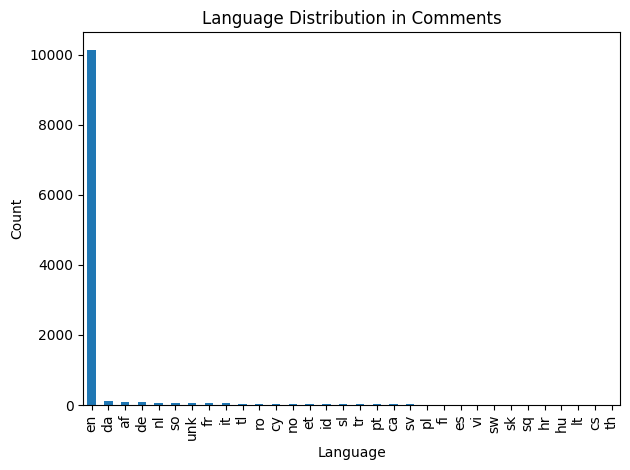

In [21]:
vc_lang = comments["lang"].value_counts().sort_values(ascending=False)
plt.figure()
vc_lang.plot(kind="bar")
plt.title("Language Distribution in Comments")
plt.xlabel("Language")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(figs_dir / "lang_dist_comments.png", dpi=150)
plt.show()

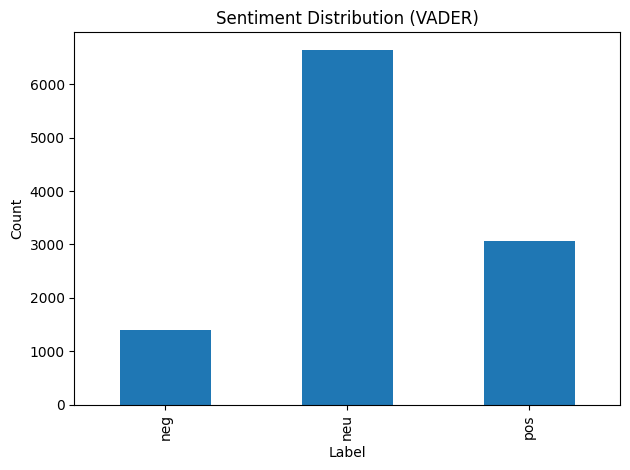

In [22]:
vc_sent = comments["sentiment_label"].value_counts().reindex(["neg","neu","pos"])
plt.figure()
vc_sent.plot(kind="bar")
plt.title("Sentiment Distribution (VADER)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(figs_dir / "sentiment_dist_vader.png", dpi=150)
plt.show()

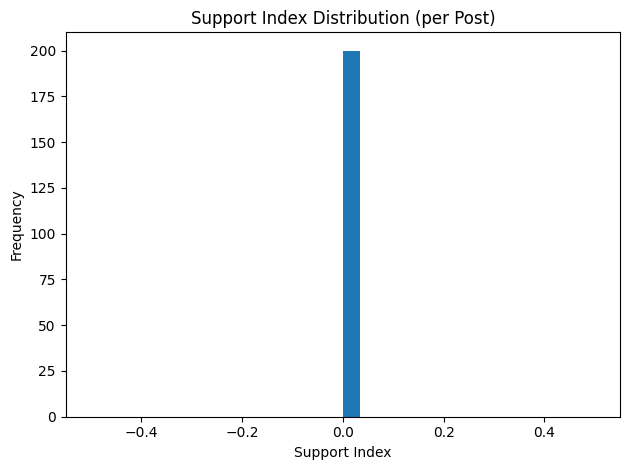

In [23]:
posts_enriched = read_df(ENRICHED_DIR / "posts_with_support.csv",
                         ENRICHED_DIR / "posts_with_support.jsonl")
if "support_index" in posts_enriched.columns:
    plt.figure()
    posts_enriched["support_index"].dropna().astype(float).plot(kind="hist", bins=30)
    plt.title("Support Index Distribution (per Post)")
    plt.xlabel("Support Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(figs_dir / "support_index_hist.png", dpi=150)
    plt.show()

## Additional Statistics

In [25]:
# Load processed comments
df = pd.read_csv("../data/processed/comments_lang_norm.csv")

# --- Sentiment distribution (from VADER) ---
sent_dist = df["sentiment_label"].value_counts(normalize=True) * 100
print("Sentiment distribution (%)")
print(sent_dist.round(2))

# --- Deleted / unknown authors ---
pct_deleted = (
    df["author"].str.lower().isin(["u/[deleted]", "unknown"]).mean() * 100
)
print("\nDeleted or unknown authors: %.2f%%" % pct_deleted)

# --- Bot comments (AutoModerator, etc.) ---
if "is_bot" in df.columns:
    pct_bot = df["is_bot"].mean() * 100
    print("Bot comments: %.2f%%" % pct_bot)

# --- Language distribution ---
if "lang" in df.columns:
    lang_dist = df["lang"].value_counts(normalize=True) * 100
    print("\nLanguage distribution (%)")
    print(lang_dist.round(2))

# --- Comments with URLs ---
if "has_url" in df.columns:
    pct_url = df["has_url"].mean() * 100
    print("\nComments containing URLs: %.2f%%" % pct_url)

# --- Median comment length ---
if "text_len" in df.columns:
    median_len = df["text_len"].median()
    print("Median text length:", median_len)

Sentiment distribution (%)
sentiment_label
neu    59.77
pos    27.65
neg    12.58
Name: proportion, dtype: float64

Deleted or unknown authors: 1.22%
Bot comments: 0.00%

Language distribution (%)
lang
en     91.12
da      0.95
af      0.87
de      0.79
nl      0.53
so      0.47
unk     0.47
fr      0.47
it      0.44
tl      0.38
ro      0.33
cy      0.32
no      0.31
et      0.31
id      0.27
sl      0.25
tr      0.24
pt      0.22
ca      0.20
sv      0.18
pl      0.13
fi      0.13
es      0.11
vi      0.09
sw      0.08
sk      0.07
sq      0.06
hr      0.06
hu      0.06
lt      0.04
cs      0.02
th      0.01
Name: proportion, dtype: float64

Comments containing URLs: 2.02%
Median text length: 80.0
